## Problem Definition

We are given a dataset of passengers of Titanic. The goal is to predict whether a passenger survived based on attributes such as their age, sex, passenger class, source of journey and so on.

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # for file operations
import matplotlib.pyplot as plt # for plotting

## Load and Explore the data.

We have 3 files provided in the [dataset](https://www.kaggle.com/c/titanic/data). Unlike the train dataset, we don't have labels in the test dataset.The goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

In [5]:
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data\gender_submission.csv
data\test.csv
data\train.csv


`gender_submission.csv` is a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Let's first read the training data.

In [56]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Based on the documentation on the [competition page](https://www.kaggle.com/c/titanic/data) the attributes have following meaning.

* **Survived**: The target label, 0 means the passenger did not survive, while 1 means passenger survived.
* **PClass**: The passenger class.
* **Name**: Name of the passenger.
* **Age**: Age of the passenger.
* **Sex**: Gender of the passenger.
* **SibSp**: The number of siblings and spouses of the passenger aborad the Titanic.
* **Parch**: The number of children and parents of the passenger aborad the Titanic.
* **Ticket**: Ticket id
* **Fare**: The fare paid in pounds
* **Cabin**: Passenger's cabin number
* **Embarked**: Where did the passenger embarked the Titanic.

Let's explore the data.

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The *Age*, *Cabin* and *Embarked* have `null` values, *Cabin* has lot of nulls (77 %), we will ignore the cabin for now.
Although *Name* and *Ticket* have valid values, but that will be tricky to convert to numerical values for model to use, so we will also ignore them.

For *Age*, we can replace the `null` values with median age. For *Embarked*, only two values are missing, we can choose the most frequent for that one.

Before, that let's take a look at numerical attributes.

In [7]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* The mean age is ~30 years. 
* Around 38% passengers survived.
* The mean fare was around $ \def\euro{\unicode{x20AC}} \euro$32.20.

Let's explore some values and ensure they are categorical. First the target variable. Also plot them for visual understanding.

In [12]:
df_train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

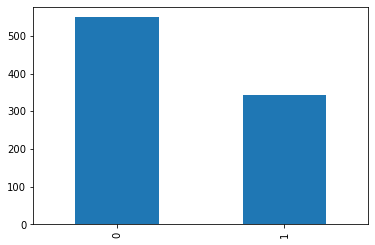

In [13]:
df_train.Survived.value_counts().sort_values(ascending=False).plot(kind='bar')
plt.show()

Now let's do the same for passenger class.

In [14]:
df_train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

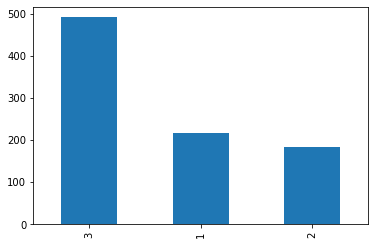

In [16]:
df_train.Pclass.value_counts().sort_values(ascending=False).plot(kind='bar')
plt.show()

Now gender

In [18]:
df_train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

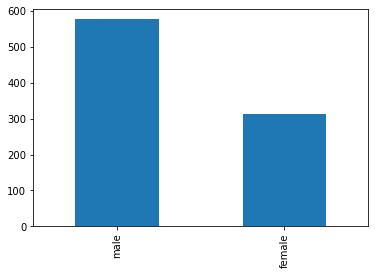

In [19]:
df_train.Sex.value_counts().sort_values(ascending=False).plot(kind='bar')
plt.show()

The `Embarked` attribute represents where did the passenger boarded Titanic.
* C = Cherbourg
* Q = Queenstown
* S = Southampton

In [24]:
df_train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

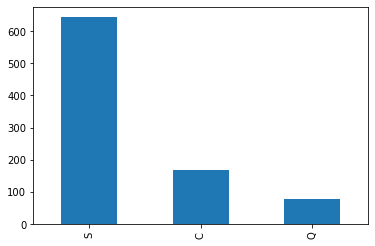

In [25]:
df_train.Embarked.value_counts().sort_values(ascending=False).plot(kind='bar')
plt.show()

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Let's buid the `Scikit-Learn` pipeline to preprocess and then train the data like we did in our end-to-end machine learning project. 

In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_attributes = ["Age", "SibSp", "Parch", "Fare"]
cat_attributes = ["Pclass", "Sex", "Embarked"]

num_pipeline = Pipeline([
    ('median_imputer', SimpleImputer(strategy='median'))
])

num_pipeline.fit_transform(df_train[num_attributes])


array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

Now, let's build a pipeline for categorical attributes, First let's build a most frequent imputer.

In [49]:
cat_pipeline = Pipeline([
        ("most_frequent_imputer", SimpleImputer(strategy='most_frequent')),
        ("cat_encoder", OneHotEncoder(sparse=False))
   ])

cat_pipeline.fit_transform(cat_data)


array([[1., 0., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       ...,
       [1., 0., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.]])

Let's combine the numerical and categorical pipelines using `ColumnTransformer`

In [51]:
from sklearn.compose import ColumnTransformer

preprocessing_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", cat_pipeline, cat_attributes)
])

X_train = preprocessing_pipeline.fit_transform(df_train)
X_train.shape

(891, 12)

In [53]:
y_train = df_train['Survived']

Awesome! We have preprocessing pipeline now. Let's train our first classifier `SVC`

In [54]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto')
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Ok, we have a trained classifier now, let's read the test data and see the predictions

In [57]:
X_test = preprocessing_pipeline.fit_transform(df_test)
y_pred = svm_clf.predict(X_test)

From `y_pred` we can build a `csv` expected by kaggle and get our score. We will do that later. Let's analyze our classifier's performance by using cross validation.

In [59]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

Accuracy is right metric here, as we have know approximately 38% people survived. So we are doing better than random prediction. Let's try another classifier `RandomForestClassifier`.

In [60]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators = 100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

Cool, the performance improved to 81%. 

To be continued...